In [1]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch

from tqdm import tqdm
import matplotlib.pyplot as plt

# Hogg's Idea

We want to learn $h^{-1}$ such that
$$
h^{-1}(\theta) \star g_{naive}^{-1}(\vec r) \star \vec N_i(g(\theta, \vec r) \cdot I(\vec r)) = \vec N_i(I(\vec r))
$$
where $\vec N_i \in \mathbb R^c \times \mathbb R^{l \times l}$, it's a vector over channels, containing images of size $l$. Note, Hogg believes $\partial_{\vec r} h^{-1} = 0$, $h^{-1}$, can be expressed independent of coordinates.

Hogg's proposition is the learned $h^{-1} $ is a real-valued matrix which acts on the level of the channels
$$
h^{-1} = \begin{pmatrix}
h_{11}^{-1} & h_{21}^{-1} & ...\\
h_{21}^{-1} & h_{22}^{-1} & ...\\
\vdots & \vdots & \ddots
\end{pmatrix} \in \mathbb M^{c \times c}(\mathbb R)
$$

## Methodology
Solve
$$
Ax = y
$$
such that $x := g_{naive}^{-1}(\vec r) \star \vec N_i(g(\theta, \vec r) \cdot I(\vec r))$ and $y := \vec N_i(I(\vec r))$. So the matrix multiplication is occurring on the level of the channels.

## Download Data

In [5]:
num_of_images = 2
target_layer = '09'
numbers = [f"{i:04}" for i in range(num_of_images)]

['14', '15', '16', '17', '18', '19']

### Load: $N(g * i)$

In [71]:
data_dir = '/vast/xj2173/diffeo/data/all_cnn_layers/'
data_name = [data_dir + f'15-100-4-4-3-224-224_image-{i}_activation_layer-{target_layer}.pt' for i in numbers]


# data[0] is the 0th picture, data[1] is the 1st picture, etc..
data = [torch.load(file_name, map_location='cpu') for file_name in tqdm(data_name)]
data = torch.stack(data, dim=0)
data.shape

100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


torch.Size([2, 1500, 48, 56, 56])

In [72]:
res_of_layer = data.shape[-1]
res_of_layer

56

### Load: $g^{-1}_{naive}$ and Apply to $g^{-1}_{naive} \star N(g * I)$
- 15 stregnths
- 100 different diffeos
- For a 244 x 244 sized image
- In 2 directions, x and y push

In [73]:
data_dir = '/vast/xj2173/diffeo/data/all_cnn_layers/'
file_name = data_dir + '15-100-4-4-3-224-224_inv_grid_sample.pt'
inv_diffeos_maps = torch.load(file_name, map_location='cpu')
inv_diffeos_maps = torch.stack(inv_diffeos_maps)
print(inv_diffeos_maps.shape)

torch.Size([15, 100, 224, 224, 2])


In [74]:
# Downsample transformation to resolution of convolutional layer

inv_diffeos_maps = inv_diffeos_maps.reshape(15 * 100, 224, 224, 2)
inv_diffeos_maps = inv_diffeos_maps.permute(0, 3, 1, 2)
inv_diffeos_maps = torch.nn.functional.interpolate(inv_diffeos_maps, size=(res_of_layer, res_of_layer), mode='bilinear', align_corners=False)
inv_diffeos_maps = inv_diffeos_maps.permute(0, 2, 3, 1)

inv_diffeos_maps.shape

torch.Size([1500, 56, 56, 2])

In [75]:
mode = 'bilinear'
data_inv = [torch.nn.functional.grid_sample(pic_data, inv_diffeos_maps, mode = mode) for pic_data in tqdm(data)]
data_inv = torch.stack(data_inv, dim=0)

data_inv.shape

  0%|          | 0/2 [00:00<?, ?it/s]/vast/cm6627/condaenv_diffeo_cnn/lib/python3.10/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


torch.Size([2, 1500, 48, 56, 56])

### Load: $N_i(I)$


In [76]:
data_dir = '/vast/xj2173/diffeo/data/reference/'
data_name = [data_dir + f'val_image-{i}_activation_layer-{target_layer}.pt' for i in numbers]

# ref_data[0] is the 0th picture, ref_data[1] is the 1st picture, etc..
ref_data = [torch.load(file_name, map_location='cpu').squeeze(0) for file_name in tqdm(data_name)]
ref_data = torch.stack(ref_data)
ref_data.shape

100%|██████████| 2/2 [00:00<00:00, 93.88it/s]


torch.Size([2, 48, 56, 56])

## Attempt 2: Matrix Inverse, Independent of Position, S.t. Matrix is Symmetric

At this level, $h^{-1}$ should be symmetric. Think of it as the adjacency matrix, and $\vec N_i(\cdot)$ as the nodes. So theres NO reason why correlations for $[\vec N_i(\cdot)]_\alpha$ over $\alpha$ should be directed... 

Our loss function $\mathcal L$ is:
$$
\forall i,j; \ \  \  \min_{[h^{-1}]_{ij}} \mathcal L = \min_{[h^{-1}]_{ij}} \left ( h^{-1} g_{naive}^{-1} N_i(g \cdot I)  -  N_i(I) \right)  + \lambda \left( \sum_{\alpha ,\beta}[h^{-1} - (h^{-1})^T]^{\mathcal w}_{\alpha \beta} \right)^{\mathcal 1/w}
$$

where the hyper-parameters $\mathcal w, \lambda \in \mathbb R$

In [35]:
image_idx = 0
diffeo_idx = 0

feature = data[image_idx, diffeo_idx, :, :, :]
label = ref_data[image_idx, :, :, :]

In [54]:
import torch
import torch.optim as optim

w = 2
# Define the loss function
def loss(A, features, labels):
    predictions = torch.einsum('ab,axy->bxy', A, features)
    return torch.mean((predictions - labels) ** 2) + _lambda * (torch.sum((A - A.T)**w))**(1/w)


# Initialize A with normal distribution
features_shape = (len(feature), len(feature))  # Replace with the actual shape of your features
A = torch.randn(features_shape, requires_grad=True)

# Hyperparameters
learning_rate = 0.00005
num_iterations = 100000
threshold = 1e-6  # Define a threshold for change in loss
patience = 100  # Define the number of iterations to wait before stopping if no improvement
counter = 0  # Initialize a counter to track the number of iterations without significant change
previous_loss = float('inf')  # Initialize the previous loss to a high value


# Define the optimizer
optimizer = optim.Adam([A], lr=learning_rate)

for i in range(num_iterations):
    optimizer.zero_grad()  # Zero the gradients before each iteration
    current_loss = loss(A, feature, label)
    current_loss.backward()  # Backpropagate to compute gradients
    optimizer.step()  # Update parameters
    
    if i % 500 == 0:
        print(f"Iteration {i}: Loss = {current_loss.item()}")
    
    # Check for early stopping
    if abs(previous_loss - current_loss.item()) < threshold:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at iteration {i}: Loss = {current_loss.item()}")
            break
    else:
        counter = 0  # Reset counter if there is significant change

    previous_loss = current_loss.item()  # Update previous loss

Iteration 0: Loss = 2195.451171875
Iteration 500: Loss = 2030.4359130859375
Iteration 1000: Loss = 1884.1798095703125
Iteration 1500: Loss = 1753.323486328125
Iteration 2000: Loss = 1635.3402099609375
Iteration 2500: Loss = 1528.337158203125
Iteration 3000: Loss = 1430.8189697265625
Iteration 3500: Loss = 1341.57470703125
Iteration 4000: Loss = 1259.634765625
Iteration 4500: Loss = 1184.244873046875
Iteration 5000: Loss = 1114.7867431640625
Iteration 5500: Loss = 1050.702392578125
Iteration 6000: Loss = 991.4789428710938
Iteration 6500: Loss = 936.6408081054688
Iteration 7000: Loss = 885.73486328125
Iteration 7500: Loss = 838.320068359375
Iteration 8000: Loss = 794.004638671875
Iteration 8500: Loss = 752.4620361328125
Iteration 9000: Loss = 713.4210205078125
Iteration 9500: Loss = 676.6492309570312
Iteration 10000: Loss = 641.9454345703125
Iteration 10500: Loss = 609.1488037109375
Iteration 11000: Loss = 578.1375122070312
Iteration 11500: Loss = 548.8052368164062
Iteration 12000: Loss 

In [56]:
def plot(tensor, start_index=0, end_index=12, title=None):
    # Define the range of indices to plot (e.g., the first 12 heatmaps)
    start_index = 0
    end_index = 12
    
    
    num_plots = end_index - start_index
    num_cols = 4  # Number of columns in the plot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Number of rows needed
    
    # Create the heatmaps
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    
    for i in range(num_plots):
        ax = axes[i // num_cols, i % num_cols]
        heatmap = tensor[start_index + i].detach().numpy()
        im = ax.imshow(heatmap, cmap='viridis')
        ax.set_title(f'Channel {start_index + i + 1}')
        ax.axis('off')
    
    # Adjust layout and show colorbar
    plt.tight_layout()

    if title:
        fig.suptitle(title, size=20)

    plt.show()

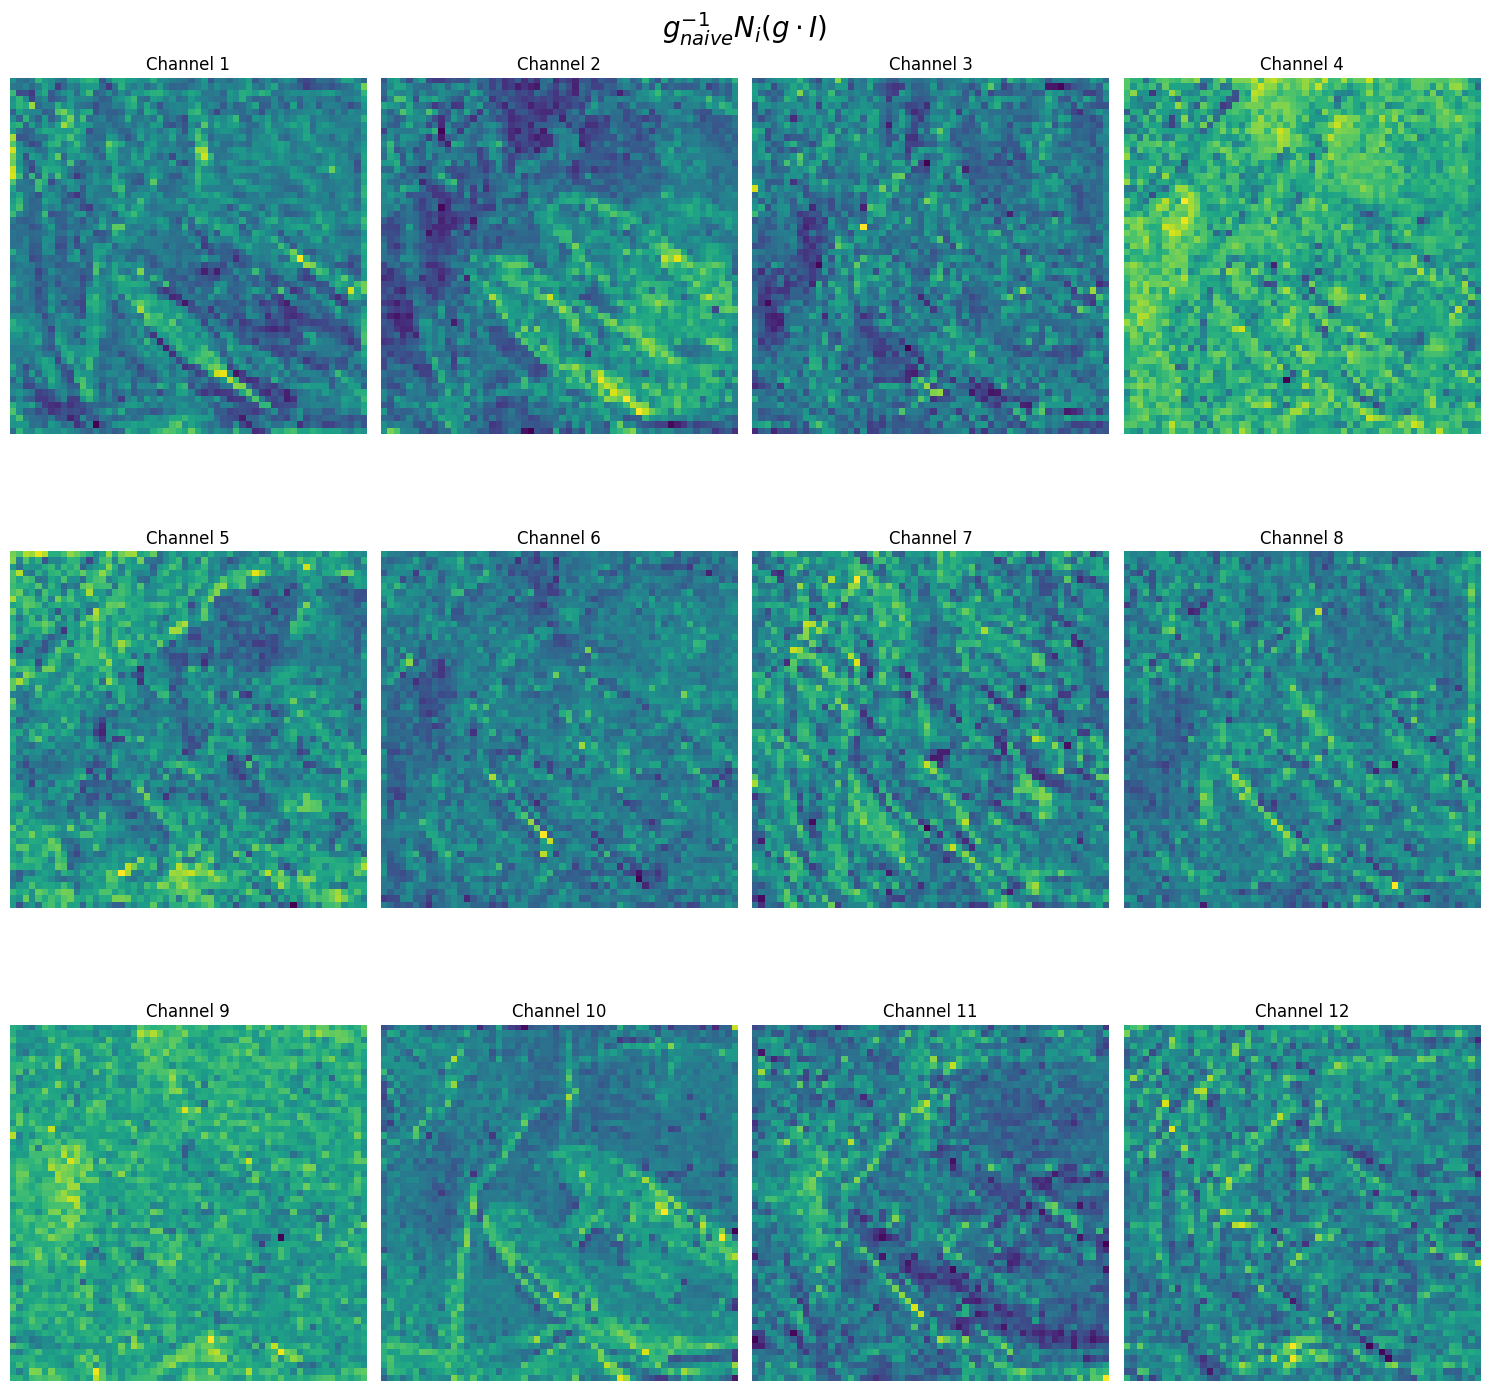

In [57]:
# Selct Image
image_idx = 0
feature = data[image_idx, diffeo_idx, :, :, :]
label = ref_data[image_idx, :, :, :]

approx_identity = torch.einsum('ab,axy->bxy', A, feature)

plot(approx_identity, title='$g^{-1}_{naive} N_i(g \cdot I)$')


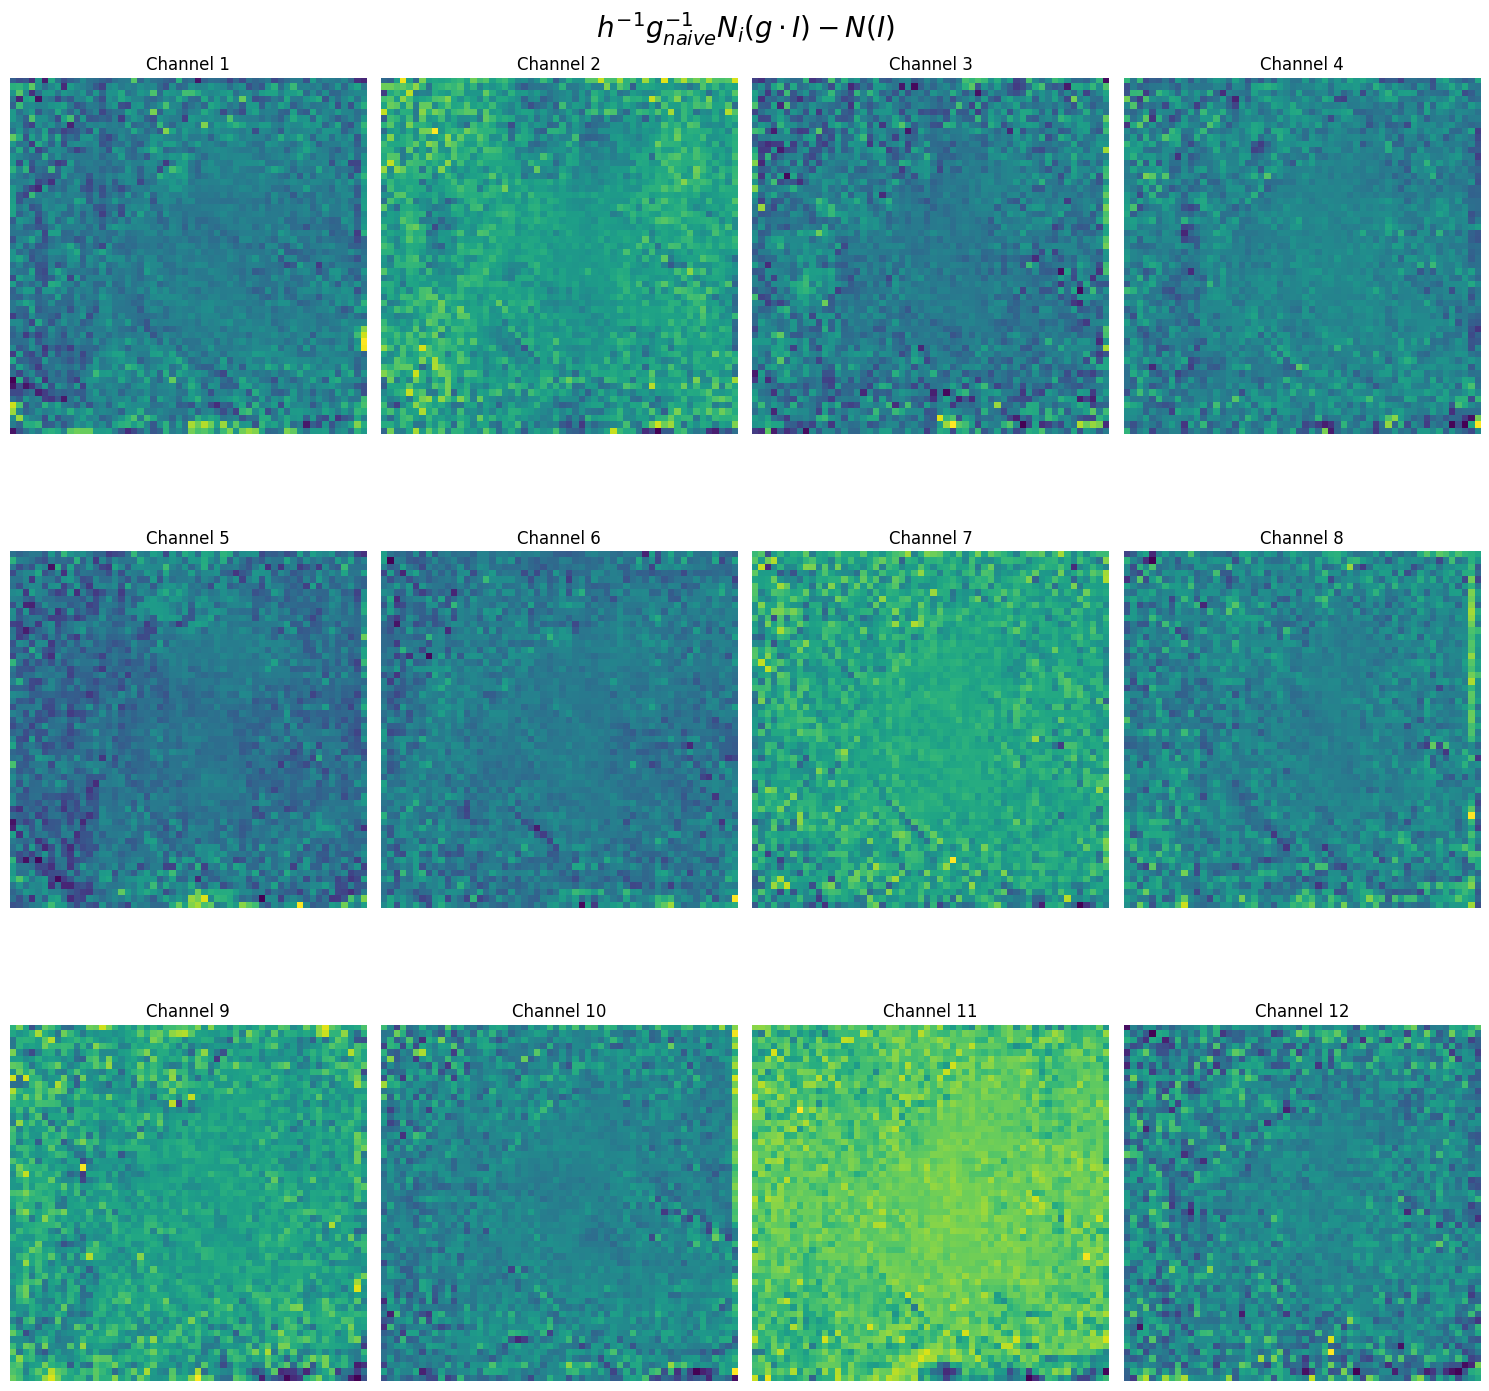

In [58]:
plot(approx_identity - label, title = '$h^{-1} g_{naive}^{-1} N_i(g \cdot I) - N(I)$')

In [61]:
torch.sum(torch.abs(approx_identity - label)) / torch.numel(approx_identity)

tensor(1.6865, grad_fn=<DivBackward0>)

In [77]:
# Different Image

image_idx = 1
diffeo_idx = 0

feature = data[image_idx, diffeo_idx, :, :, :]
label = ref_data[image_idx, :, :, :]

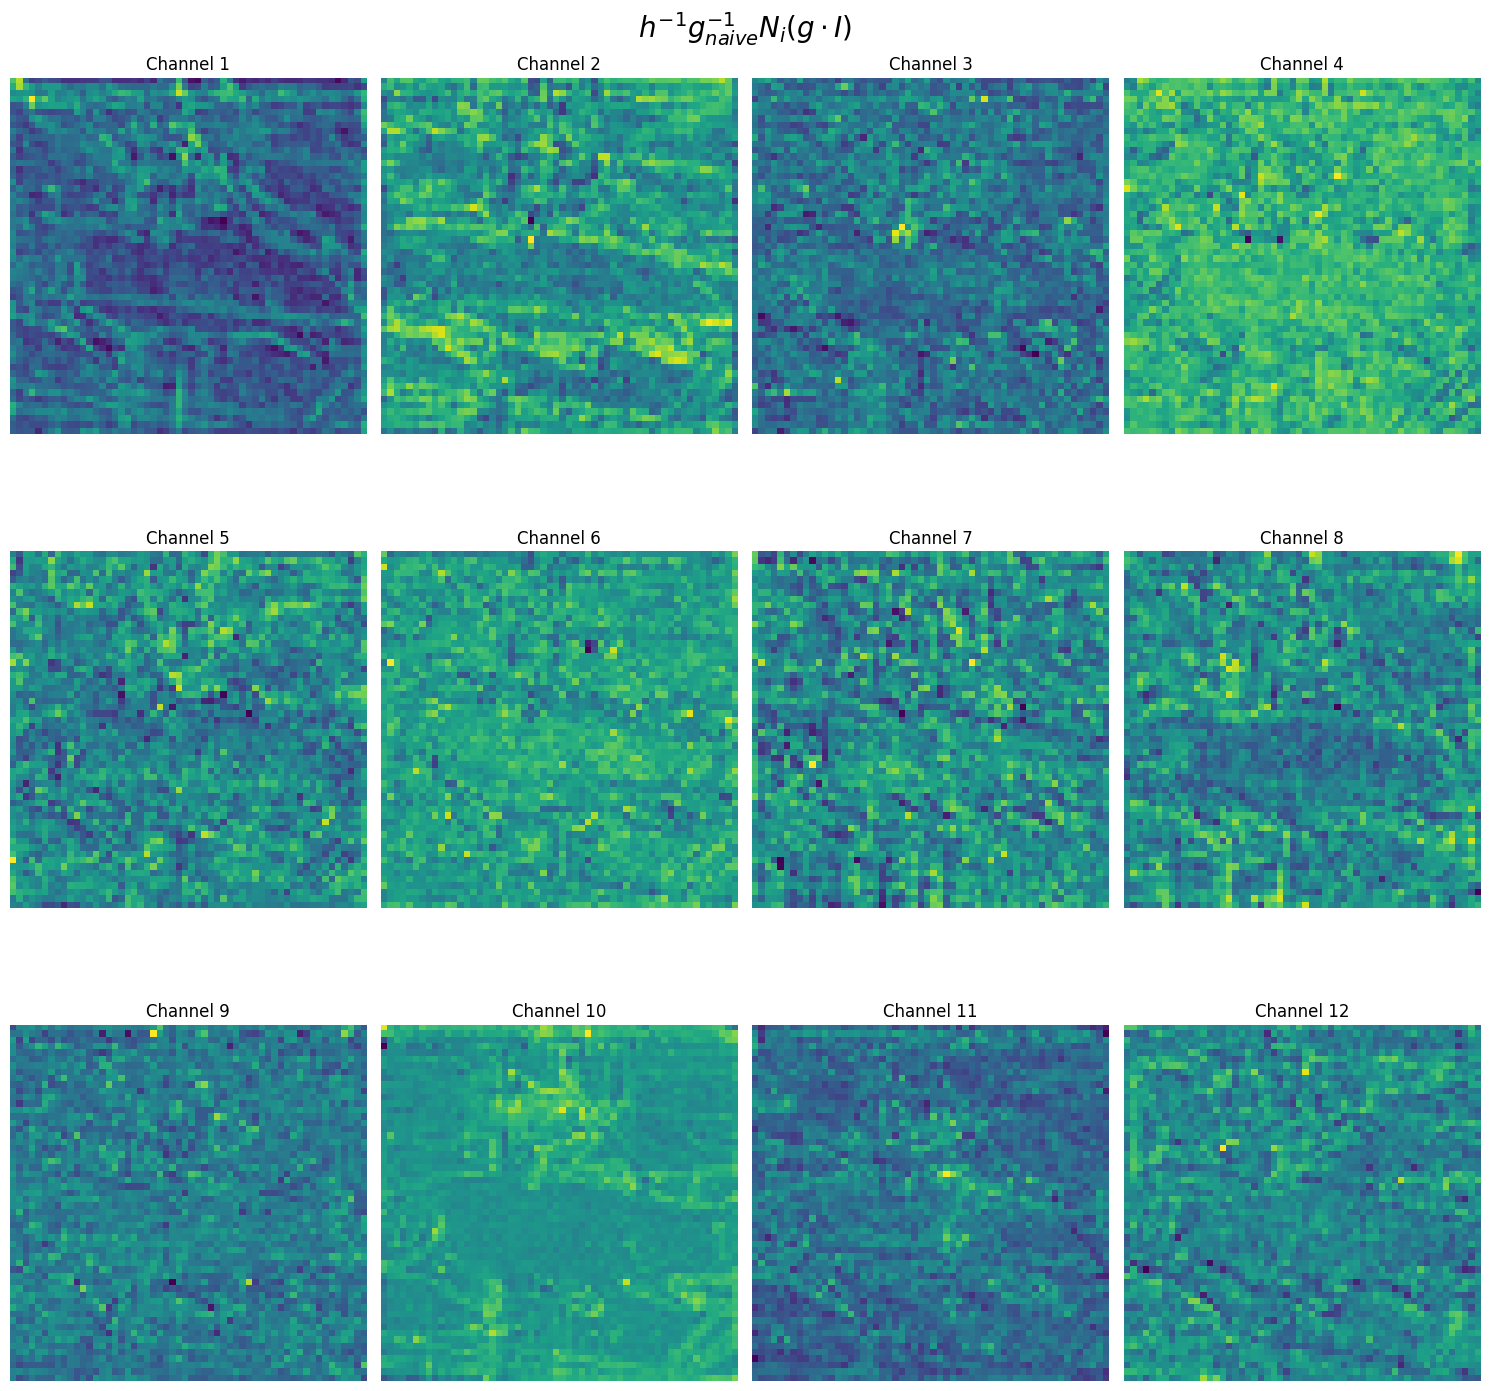

In [79]:
approx_identity = torch.einsum('ab,axy->bxy', A, feature)
plot(approx_identity, title='$h^{-1} g^{-1}_{naive} N_i(g \cdot I)$')

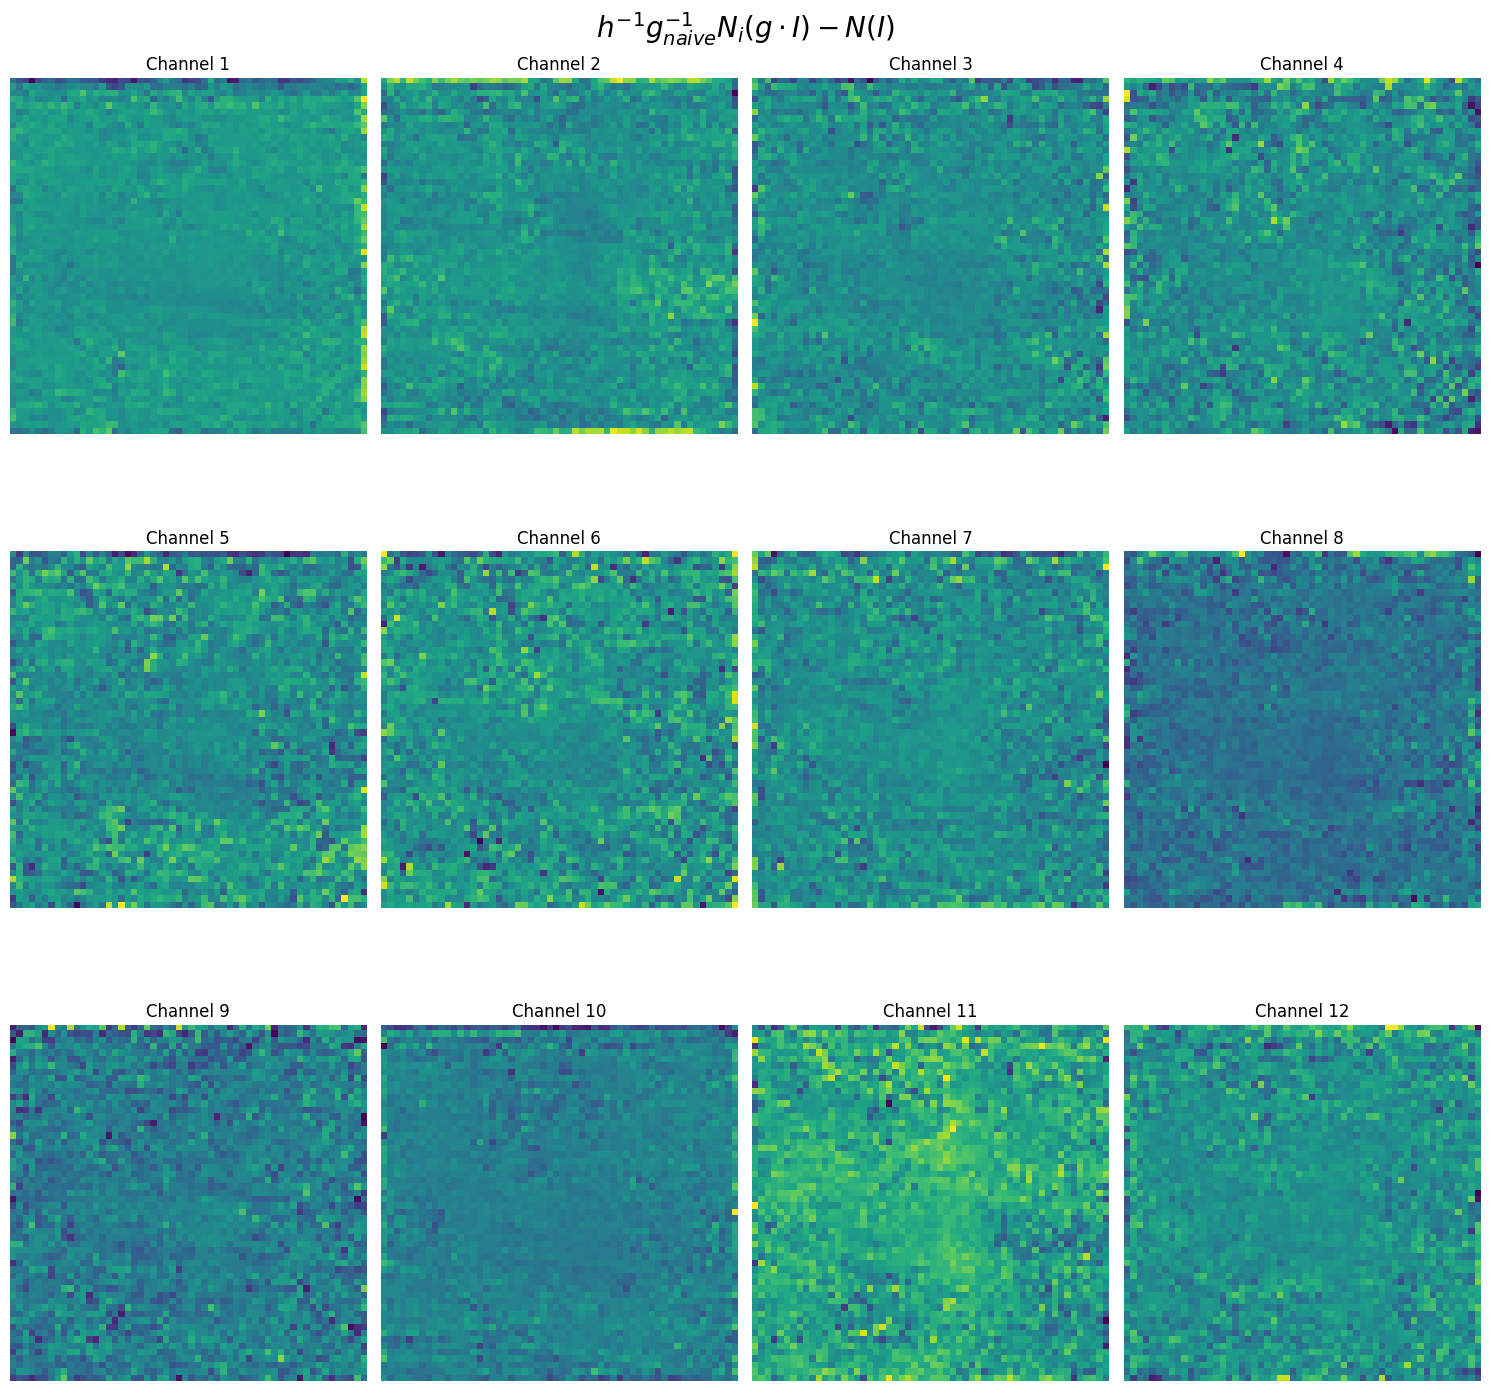

In [80]:
plot(approx_identity - label, title = '$h^{-1} g_{naive}^{-1} N_i(g \cdot I) - N(I)$')

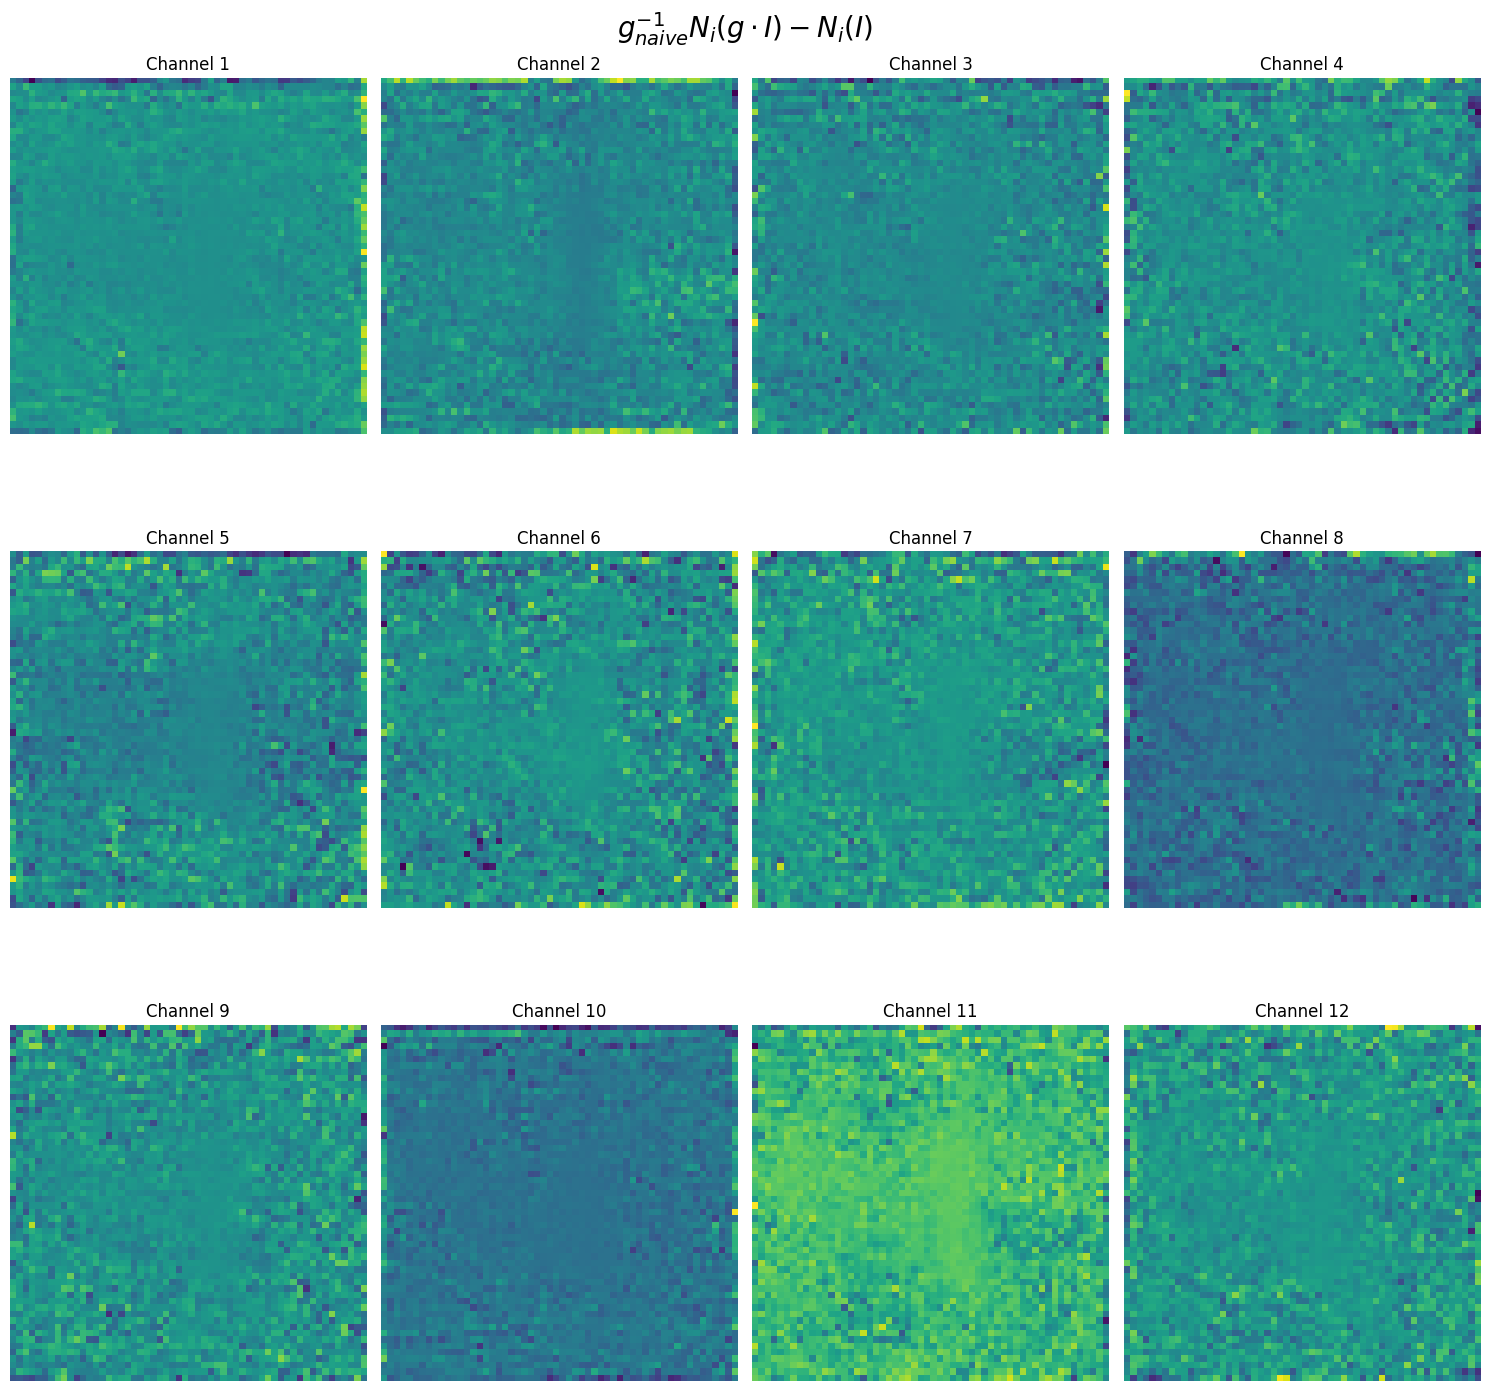

In [82]:
plot(feature - label, title='$g^{-1}_{naive} N_i(g \cdot I) - N_i (I)$')

$g_{naive}^{-1} N_i(g \cdot I) = \mathbb I  + \epsilon$

## Attempt 1: Matrix Inverse, Independent of Position

In this case, entries of $h^{-1}$ have the same value at every pixel position

Our loss function $\mathcal L$ is:
$$
\forall i,j; \ \  \  \min_{[h^{-1}]_{ij}} \mathcal L = \min_{[h^{-1}]_{ij}} \left ( h^{-1} g_{naive}^{-1} N_i(g \cdot I)  -  N_i(I)\right) 
$$

In [62]:
image_idx = 0
diffeo_idx = 0

feature = data[image_idx, diffeo_idx, :, :, :]
label = ref_data[image_idx, :, :, :]

In [63]:
import torch
import torch.optim as optim

# Define the loss function
def loss(A, features, labels):
    predictions = torch.einsum('ab,axy->bxy', A, features)
    return torch.mean((predictions - labels) ** 2)


# Initialize A with normal distribution
features_shape = (len(feature), len(feature))  # Replace with the actual shape of your features
A = torch.randn(features_shape, requires_grad=True)

# Hyperparameters
learning_rate = 0.0001
num_iterations = 100000
threshold = 1e-6  # Define a threshold for change in loss
patience = 100  # Define the number of iterations to wait before stopping if no improvement
counter = 0  # Initialize a counter to track the number of iterations without significant change
previous_loss = float('inf')  # Initialize the previous loss to a high value


# Define the optimizer
optimizer = optim.Adam([A], lr=learning_rate)

for i in range(num_iterations):
    optimizer.zero_grad()  # Zero the gradients before each iteration
    current_loss = loss(A, feature, label)
    current_loss.backward()  # Backpropagate to compute gradients
    optimizer.step()  # Update parameters
    
    if i % 500 == 0:
        print(f"Iteration {i}: Loss = {current_loss.item()}")
    
    # Check for early stopping
    if abs(previous_loss - current_loss.item()) < threshold:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at iteration {i}: Loss = {current_loss.item()}")
            break
    else:
        counter = 0  # Reset counter if there is significant change

    previous_loss = current_loss.item()  # Update previous loss

Iteration 0: Loss = 2019.4600830078125
Iteration 500: Loss = 1723.833740234375
Iteration 1000: Loss = 1493.8631591796875
Iteration 1500: Loss = 1308.5272216796875
Iteration 2000: Loss = 1155.5452880859375
Iteration 2500: Loss = 1027.067626953125
Iteration 3000: Loss = 917.7001342773438
Iteration 3500: Loss = 823.6102294921875
Iteration 4000: Loss = 741.9513549804688
Iteration 4500: Loss = 670.4776611328125
Iteration 5000: Loss = 607.3506469726562
Iteration 5500: Loss = 551.053466796875
Iteration 6000: Loss = 500.3591003417969
Iteration 6500: Loss = 454.31585693359375
Iteration 7000: Loss = 412.2362060546875
Iteration 7500: Loss = 373.6719665527344
Iteration 8000: Loss = 338.3243103027344
Iteration 8500: Loss = 305.9552001953125
Iteration 9000: Loss = 276.3496398925781
Iteration 9500: Loss = 249.3077392578125
Iteration 10000: Loss = 224.64385986328125
Iteration 10500: Loss = 202.18421936035156
Iteration 11000: Loss = 181.7652130126953
Iteration 11500: Loss = 163.23231506347656
Iteration

In [64]:
def plot(tensor, start_index=0, end_index=12, title=None):
    # Define the range of indices to plot (e.g., the first 12 heatmaps)
    start_index = 0
    end_index = 12
    
    
    num_plots = end_index - start_index
    num_cols = 4  # Number of columns in the plot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Number of rows needed
    
    # Create the heatmaps
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    
    for i in range(num_plots):
        ax = axes[i // num_cols, i % num_cols]
        heatmap = tensor[start_index + i].detach().numpy()
        im = ax.imshow(heatmap, cmap='viridis')
        ax.set_title(f'Channel {start_index + i + 1}')
        ax.axis('off')
    
    # Adjust layout and show colorbar
    plt.tight_layout()

    if title:
        fig.suptitle(title, size=20)

    plt.show()

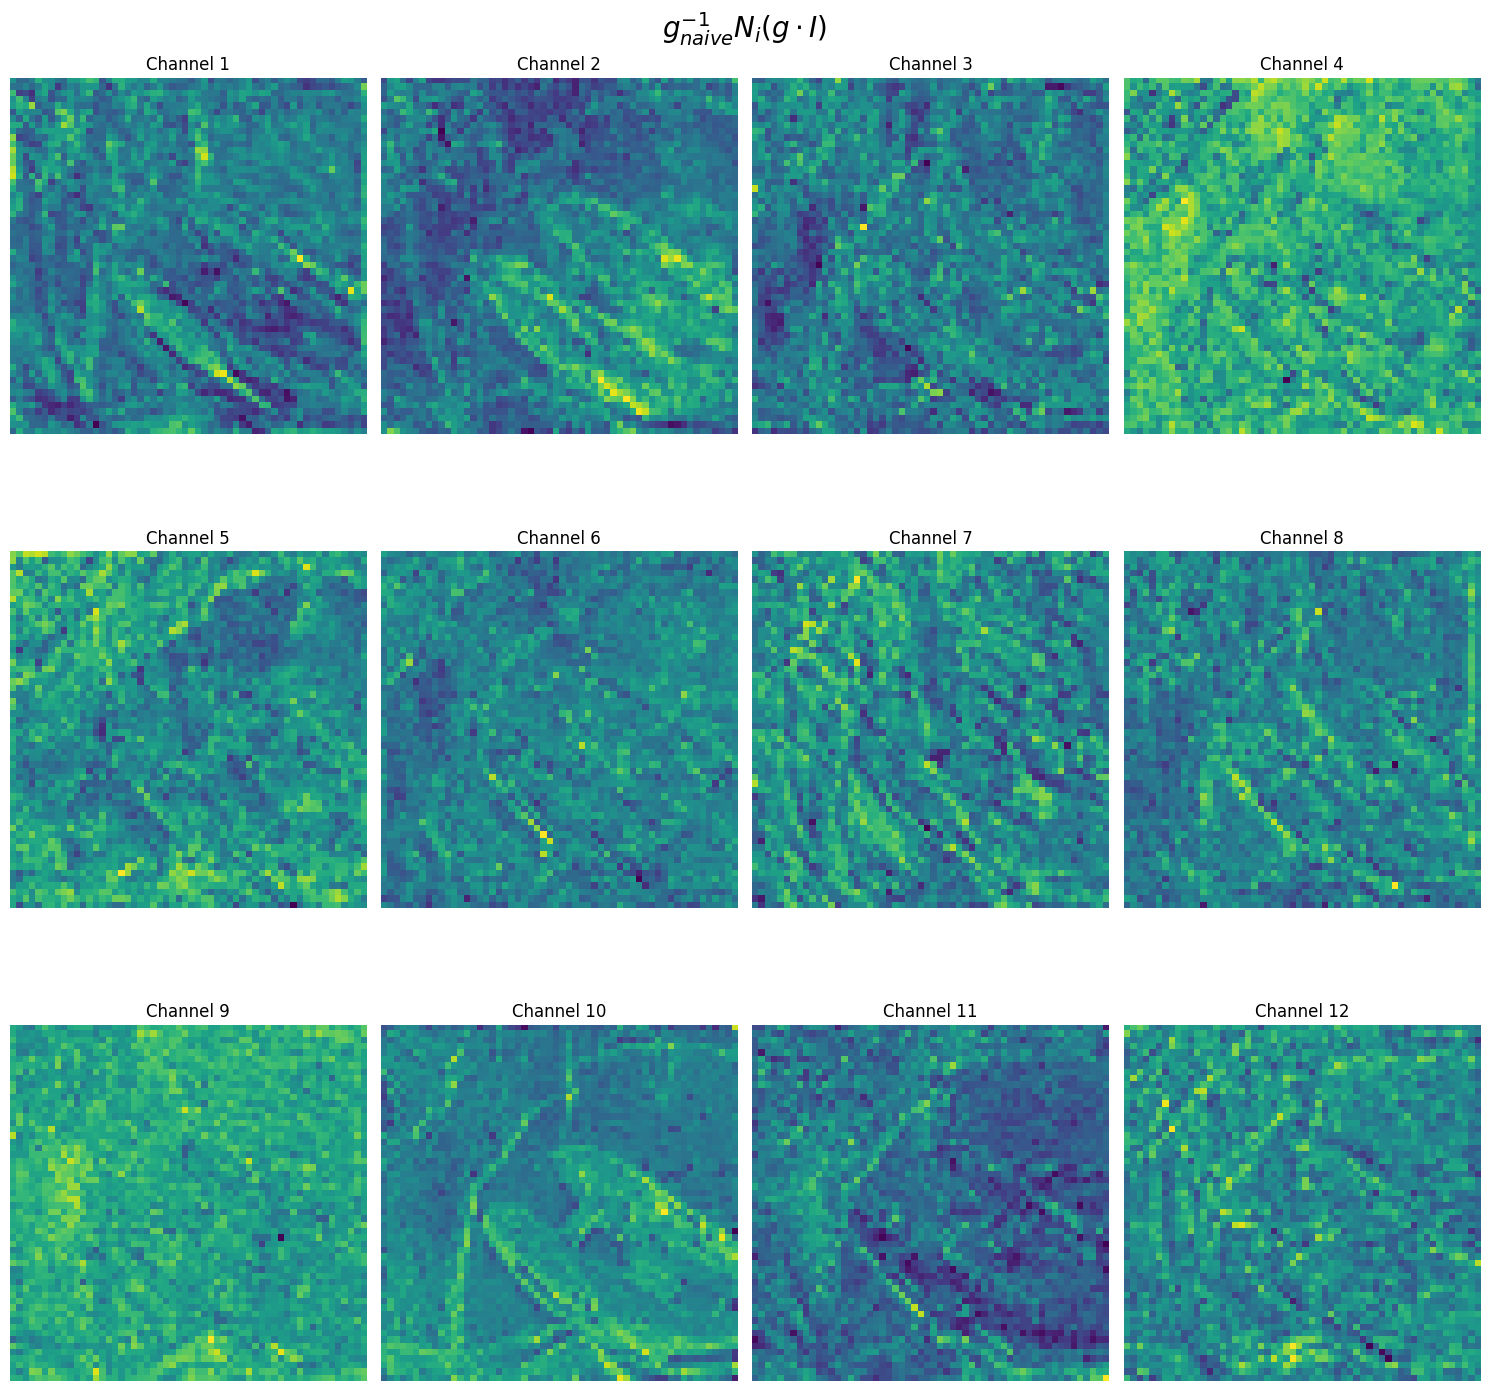

In [65]:
# Selct Image
image_idx = 0
feature = data[image_idx, diffeo_idx, :, :, :]
label = ref_data[image_idx, :, :, :]

approx_identity = torch.einsum('ab,axy->bxy', A, feature)

plot(approx_identity, title='$g^{-1}_{naive} N_i(g \cdot I)$')


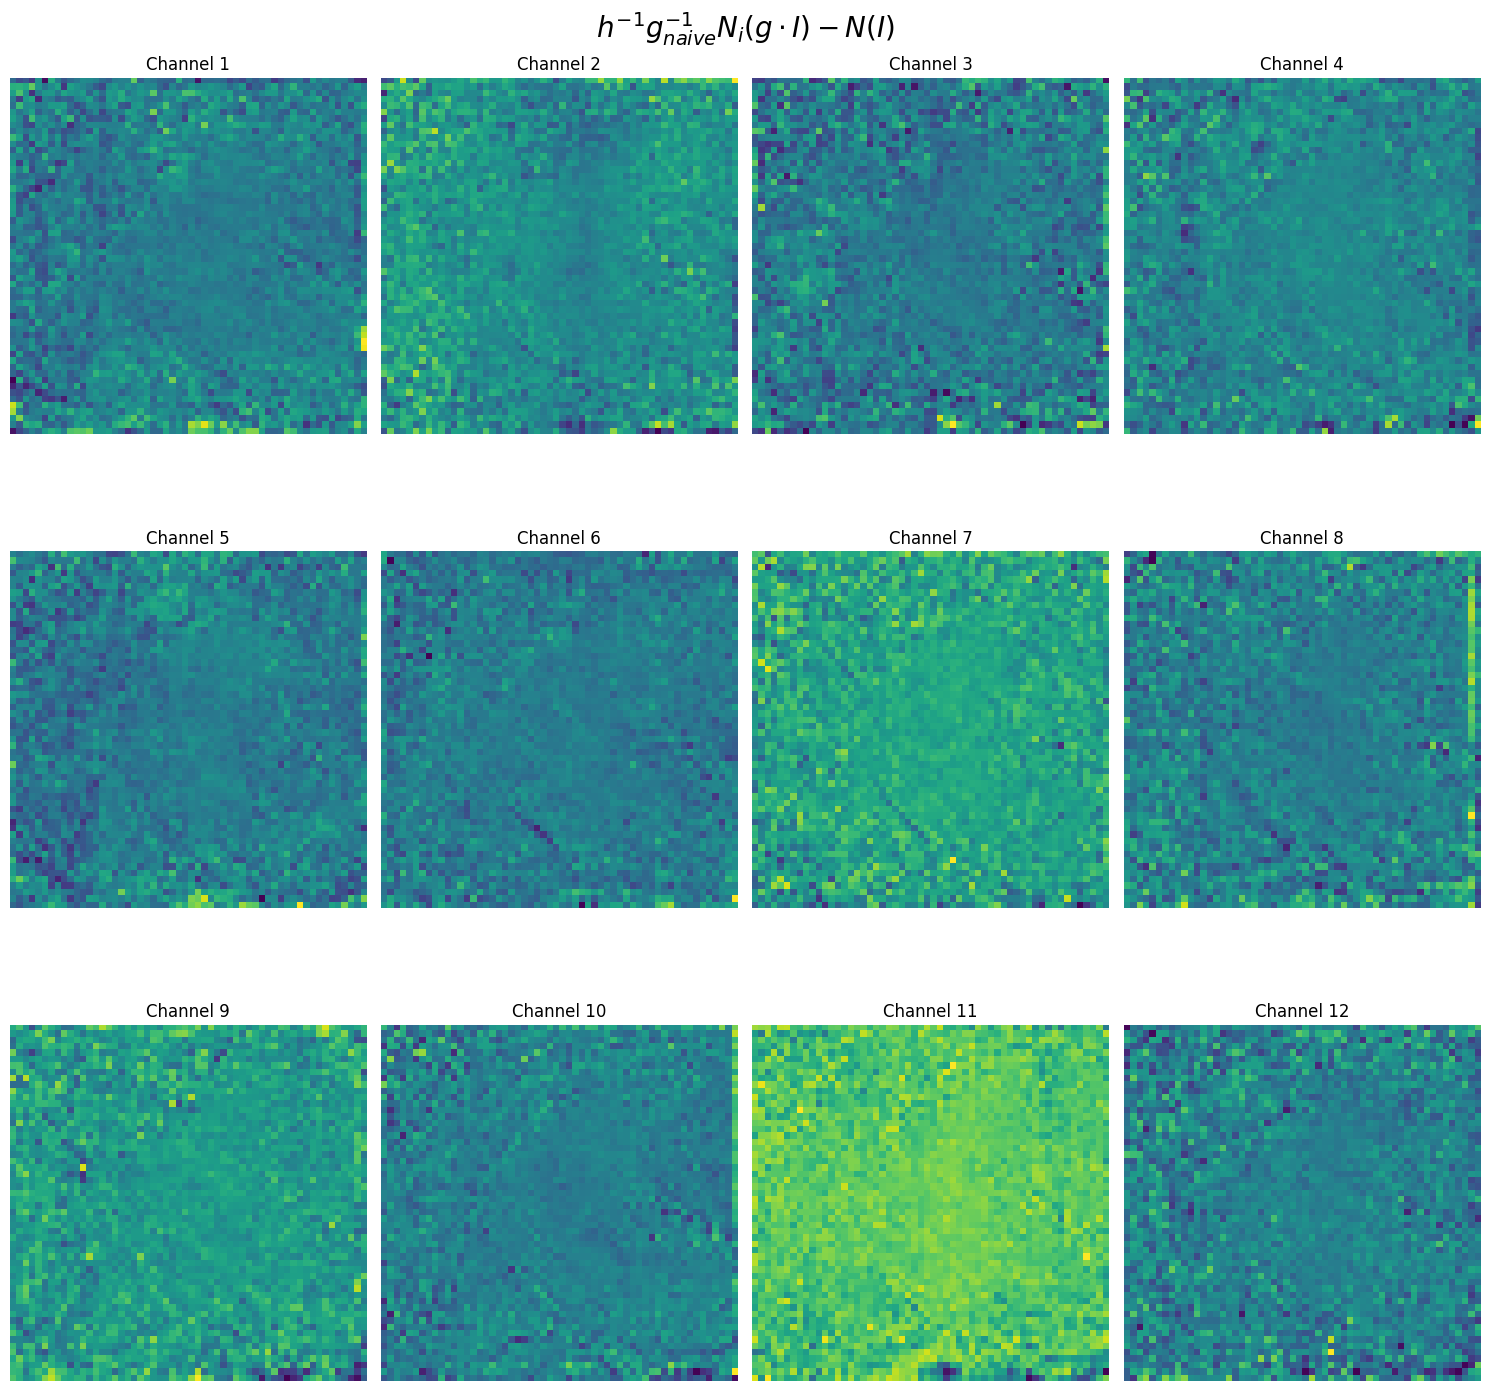

In [66]:
plot(approx_identity - label, title = '$h^{-1} g_{naive}^{-1} N_i(g \cdot I) - N(I)$')

In [67]:
torch.sum(torch.abs(approx_identity - label)) / torch.numel(approx_identity)

tensor(1.6580, grad_fn=<DivBackward0>)